<a href="https://colab.research.google.com/github/srvmishra/Language-Models/blob/main/text_classification_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap-learn transformers datasets accelerate

### Imports

In [ ]:
import numpy as np
import pandas as pd
import markdown
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy

from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load and inspect dataset

In [ ]:
emotions = load_dataset('emotion')

print('#Train samples ', len(emotions['train']))
print('#Validation samples', len(emotions['validation']))
print('#Test samples ', len(emotions['test']))

print('Features ', emotions['train'].features)
print('Column Names ', emotions['train'].column_names)
print('Class Labels ', emotions['train'].features['label'].names)

print('Texts ', emotions['train']['text'][:5])
print('Labels ', emotions['train']['label'][:5])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

#Train samples  16000
#Validation samples 2000
#Test samples  2000
Features  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Column Names  ['text', 'label']
Class Labels  ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Texts  ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
Labels  [0, 0, 3, 2, 3]


### Add label names and tweet lengths to the datasets

In [ ]:
def add_label_names_and_text_length(example):
    return {'label name': emotions['train'].features['label'].names[example['label']],
            'tweet length': len(example['text'].split())}

emotions_with_names = emotions.map(add_label_names_and_text_length, batched=False)
emotions_with_names = emotions_with_names.rename_column('label', 'labels')

print('Column Names ', emotions_with_names['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Column Names  ['text', 'labels', 'label name', 'tweet length']


### Distribution of tweets by emotion

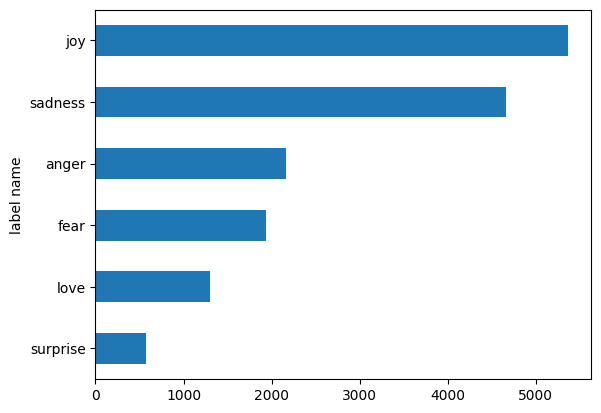

In [ ]:
emotions_with_names.set_format('pandas')
df = emotions_with_names['train'][:]

df.value_counts('label name', ascending=True).plot.barh()
plt.show()

### Tweet length distribution across emotions

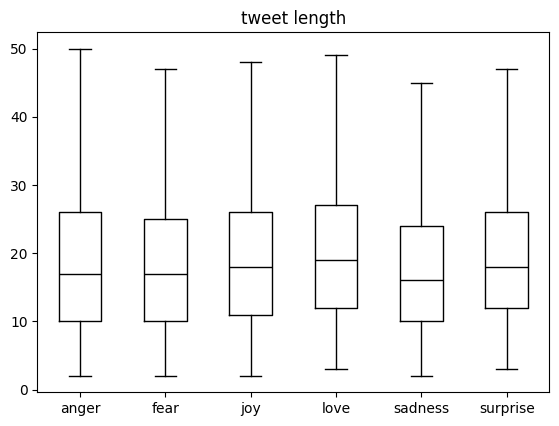

In [ ]:
df.boxplot('tweet length', by='label name', showfliers=False, grid=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

### Tokenize dataset

In [ ]:
emotions_with_names.reset_format()

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_batch(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

emotions_tokenized = emotions_with_names.map(tokenize_batch, batched=True)
print('Column Names ', emotions_tokenized['train'].column_names)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Column Names  ['text', 'labels', 'label name', 'tweet length', 'input_ids', 'attention_mask']


### Extract features from DistilBERT model for sklearn classifiers

In [ ]:
emotions_tokenized.set_format('torch', columns=tokenizer.model_input_names+['labels'])

model = AutoModel.from_pretrained(model_ckpt).to(device)

def extract_features(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in \
              tokenizer.model_input_names}

    with torch.no_grad():
        v = model(**inputs).last_hidden_state[:, 0]
    return {'context': v.cpu().numpy()}

emotions_with_features = emotions_tokenized.map(extract_features, batched=True)
print('Column Names ', emotions_with_features['train'].column_names)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Column Names  ['text', 'labels', 'label name', 'tweet length', 'input_ids', 'attention_mask', 'context']


### Reduce dimensions and visualize samples for each emotion

In [ ]:
Xtrain, Xtest = emotions_with_features['train']['context'], emotions_with_features['test']['context']
ytrain, ytest = emotions_with_features['train']['labels'], emotions_with_features['test']['labels']

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


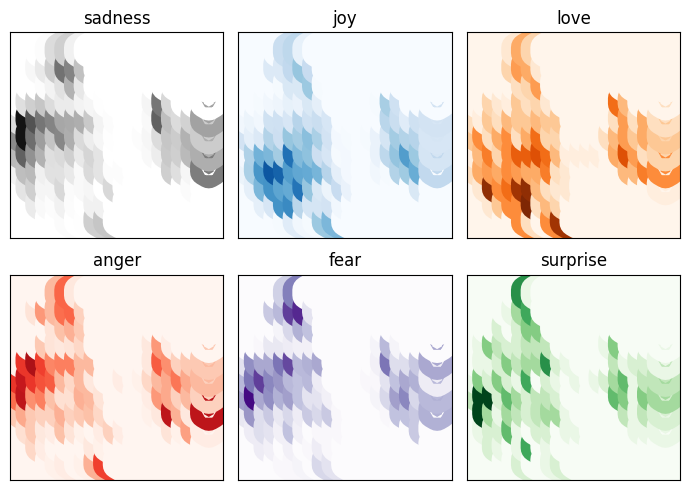

In [ ]:
mms = MinMaxScaler()
Xtrain_scaled = mms.fit_transform(Xtrain)
um = UMAP(n_components=2, metric='cosine')
embeds = um.fit_transform(Xtrain_scaled)

df_emb = pd.DataFrame(embeds, columns=['x', 'y'])
df_emb['labels'] = ytrain

# plot stuff
fig, axs = plt.subplots(2, 3, figsize=(7, 5))
axes = axs.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb[df_emb['labels'] == i]
    axes[i].hexbin(df_emb_sub['x'], df_emb_sub['y'], gridsize=20, cmap=cmap, linewidth=(20,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Function for plotting confusion matrix

In [ ]:
def plot_conf_matrix(ax, predictions, targets, labels, title):
    cm = confusion_matrix(targets, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    ax.set_title('Normalized CM: {}'.format(title))
    return

### sklearn classifiers - Logistic Regression, SVM, Random Forest

In [ ]:
lr = LogisticRegression(max_iter=1000)
sv = SVC(max_iter=1000)
rf = RandomForestClassifier(n_estimators=8)

lr.fit(Xtrain, ytrain)
sv.fit(Xtrain, ytrain)
rf.fit(Xtrain, ytrain)

lr_preds = lr.predict(Xtest)
sv_preds = sv.predict(Xtest)
rf_preds = rf.predict(Xtest)

lr_acc = accuracy_score(ytest, lr_preds)
lr_f1 = f1_score(ytest, lr_preds, average='weighted')
sv_acc = accuracy_score(ytest, sv_preds)
sv_f1 = f1_score(ytest, sv_preds, average='weighted')
rf_acc = accuracy_score(ytest, rf_preds)
rf_f1 = f1_score(ytest, rf_preds, average='weighted')

print('Logistic Regression: f1 score {:.2f}, accuracy score {:.2f}'.format(lr_f1, lr_acc))
print('SVM: f1 score {:.2f}, accuracy score {:.2f}'.format(sv_f1, sv_acc))
print('Random Forest: f1 score {:.2f}, accuracy score {:.2f}'.format(rf_f1, rf_acc))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Logistic Regression: f1 score 0.61, accuracy score 0.63
SVM: f1 score 0.28, accuracy score 0.30
Random Forest: f1 score 0.41, accuracy score 0.46


### DistilBERT finetuning - load model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define metric functions to monitor performance during training

In [ ]:
def compute_metrics(predictions):
    labels = predictions.label_ids
    preds = predictions.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

### Define trainer and train model

In [ ]:
batch_size = 64
logging_steps = len(emotions_tokenized['train'])//batch_size
model_name = f'srvmishra832/text-classification/emotions-dataset-{model_ckpt}'
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=5, learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01, evaluation_strategy='epoch', disable_tqdm=False,
                                  logging_steps=logging_steps, push_to_hub=True, log_level='error')

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                  train_dataset=emotions_tokenized['train'],
                  eval_dataset=emotions_tokenized['test'],
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

<ipython-input-19-fb6312e4d983>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: srvmishra832 (srvmishra832-indian-institute-of-science-bangalore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.778700,0.256352,0.912500,0.913944
2,0.204700,0.186904,0.922500,0.923428
3,0.132900,0.170524,0.923000,0.923911
4,0.104500,0.161797,0.924000,0.923881
5,0.086600,0.161282,0.926500,0.926125


events.out.tfevents.1741504112.adf209d5db79.1151.0:   0%|          | 0.00/8.63k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srvmishra832/emotions-dataset-distilbert-base-uncased/commit/f02f498379eff4db407a2b3db8bc313a35e96901', commit_message='End of training', commit_description='', oid='f02f498379eff4db407a2b3db8bc313a35e96901', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srvmishra832/emotions-dataset-distilbert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='srvmishra832/emotions-dataset-distilbert-base-uncased'), pr_revision=None, pr_num=None)

### Collect model predictions and performance on test set

In [ ]:
predictions = trainer.predict(emotions_tokenized['test'])
tf_preds = predictions.predictions.argmax(-1)
tf_acc = accuracy_score(ytest, tf_preds)
tf_f1 = f1_score(ytest, tf_preds, average='weighted')
print(predictions.metrics)

{'test_loss': 0.16128210723400116, 'test_accuracy': 0.9265, 'test_f1': 0.9261250804902244, 'test_runtime': 3.6683, 'test_samples_per_second': 545.217, 'test_steps_per_second': 8.723}


### Compare confusion matrices of all classification methods

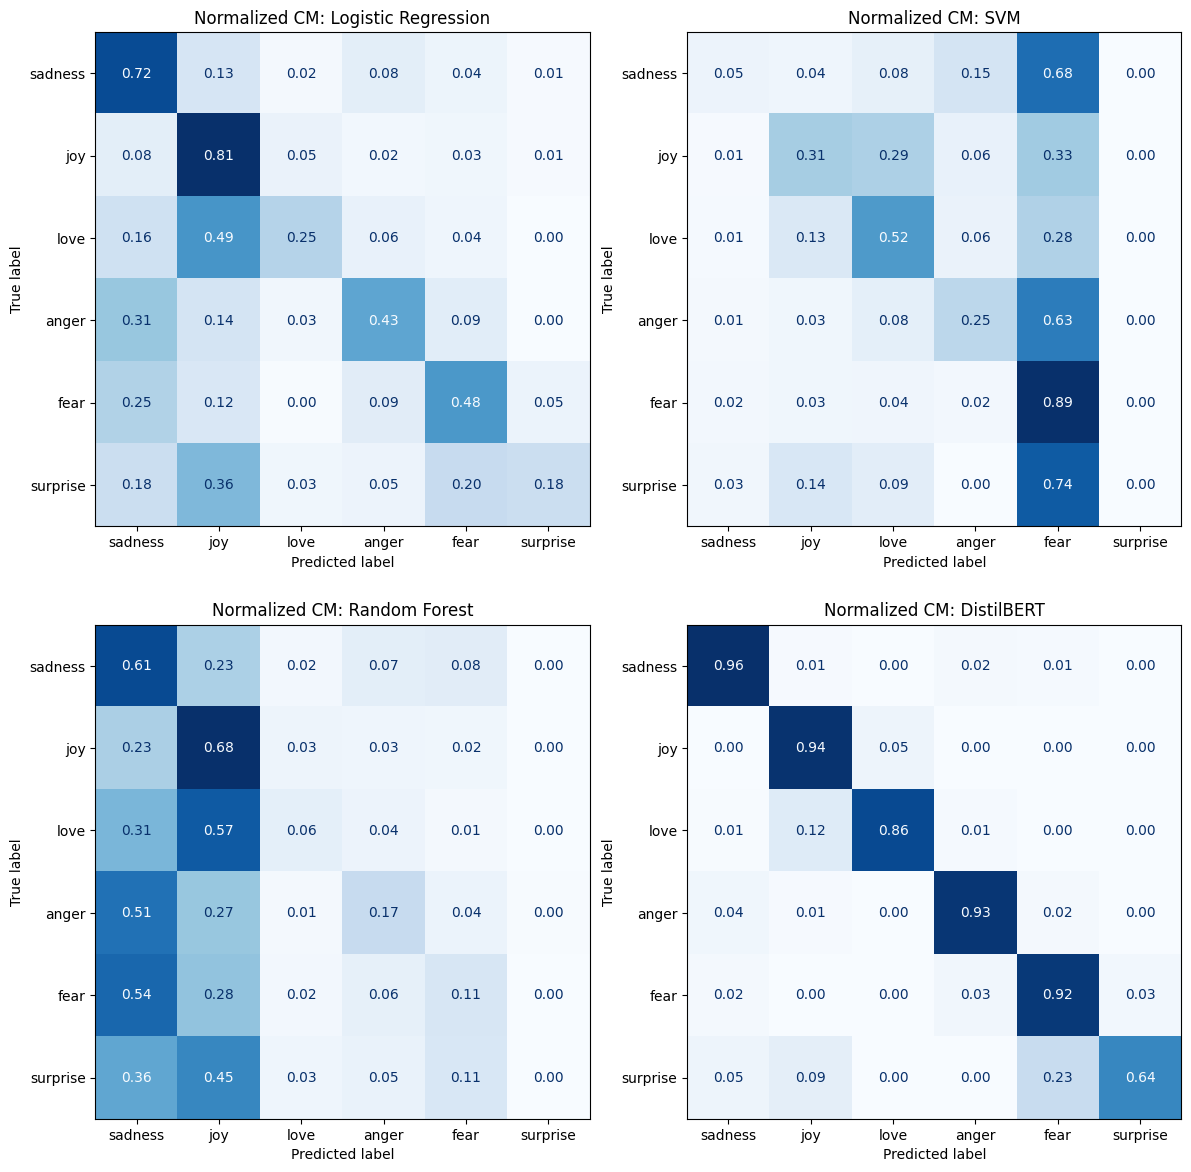

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axes = axs.flatten()
predictions = [lr_preds, sv_preds, rf_preds, tf_preds]
accuracies = [lr_acc, sv_acc, rf_acc, tf_acc]
f1s = [lr_f1, sv_f1, rf_f1, tf_f1]
titles = ['Logistic Regression', 'SVM', 'Random Forest', 'DistilBERT']

for ax, pred, title in zip(axes, predictions, titles):
    plot_conf_matrix(ax, pred, ytest, emotions_with_names['train'].features['labels'].names, title)

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.tight_layout()
plt.show()

### Inspect model performance on test set - test losses and predictions

In [ ]:
def loss_and_tf_preds(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in \
              tokenizer.model_input_names}

    with torch.no_grad():
        outputs = model(**inputs)
        pred = outputs.logits.argmax(dim=-1)
        loss = cross_entropy(outputs.logits, batch['labels'].to(device), reduction='none')
    return {'loss': loss.cpu().numpy(), 'predictions': pred.cpu().numpy()}

emotions_tokenized['test'] = emotions_tokenized['test'].map(loss_and_tf_preds, batched=True)
print('Columns in test set ', emotions_tokenized['test'].column_names)

emotions_tokenized.set_format('pandas')
cols = ['text', 'labels', 'predictions', 'loss']
df = emotions_tokenized['test'][:][cols]
df['pred label name'] = df['predictions'].apply(lambda row: \
                                                emotions_with_names['train'].features['labels'].names[row])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Columns in test set  ['text', 'labels', 'label name', 'tweet length', 'input_ids', 'attention_mask', 'loss', 'predictions']


### Test samples with maximum loss

In [ ]:
df.sort_values('loss', ascending=False).head(10)

,text,labels,predictions,loss,pred label name
816,whenever i put myself in others shoes and try ...,3,1,7.720290,joy
125,i feel very mislead by someone that i really r...,2,3,6.380458,anger
1382,i cannot even begin to express in words the de...,5,0,6.307877,sadness
468,i cant help feeling this way,0,1,5.823268,joy
1928,i feel inside cause life is like a game someti...,4,0,5.676009,sadness
150,im feeling rather angsty and listless,0,2,5.596075,love
1533,i actually was in a meeting last week where so...,3,0,5.456026,sadness
1377,i walked to school he felt the bounce in his s...,2,1,5.144149,joy
1613,i feel very cheated since i am supporting the ...,1,0,4.890141,sadness
426,i feel unprotected a class post count link hre...,0,4,4.835025,fear


### Test samples with minimum loss

In [ ]:
df.sort_values('loss', ascending=True).head(10)

,text,labels,predictions,loss,pred label name
1651,i feel like a bit of an ungrateful fool for no...,0,0,0.002270,sadness
1494,i feel like an ungrateful ass a href http this...,0,0,0.002311,sadness
882,ive been feeling sort of depressed,0,0,0.002317,sadness
1668,i feel groggy and out of sorts from my episode...,0,0,0.002324,sadness
1582,i can t look at for too long without feeling d...,0,0,0.002376,sadness
1538,i feel so wiggy about everything maybe ill jus...,1,1,0.002377,joy
547,i feel a little virtuous doing these things bu...,1,1,0.002379,joy
725,i feel kind of unwelcome in many catholic comm...,0,0,0.002384,sadness
1753,i dont know but i feel virtuous so i accept th...,1,1,0.002385,joy
293,i start to feel unloved and unappreciated,0,0,0.002387,sadness
